In [1]:
from __future__ import absolute_import, division, print_function

In [ ]:
# License: MIT

# Calculation of HadISST SST anomalies

This notebook contains the analysis of the HadISST SST data used to produce
a set of SST anomalies for our case studies.

## Packages

In [2]:
%matplotlib inline

import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.optimize import curve_fit
from scipy.stats import linregress

## File paths

The input SST data is assumed to be located at data/HadISST_sst.nc. If necessary,
the data can be downloaded first using the script provided in the bin/ directory.

In [3]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'nc')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
SST_INPUT_FILE = os.path.join(DATA_DIR, 'HadISST_sst.nc')

if not os.path.exists(SST_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_INPUT_FILE)

## Analysis parameters

In [4]:
# First and last years to include in analysis
START_YEAR = 1870
END_YEAR = 2018

# First and last years to include in climatology for seasonal cycle
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Used to identify unrealistic values of SST
MIN_VALID_SST = -30.0

TIME_NAME = 'time'
LAT_NAME = 'latitude'
LON_NAME = 'longitude'
VARIABLE_NAME = 'sst'

# Period in months of seasonal cycle to fit
SEASONAL_CYCLE_PERIOD = 12

# Order of trend to fit
ANOMALY_TREND_ORDER = 1

## Helper functions

In [5]:
def calculate_seasonal_cycle(da, period=SEASONAL_CYCLE_PERIOD,
                             base_period_start_year=None,
                             base_period_end_year=None, time_name=TIME_NAME):
    """Calculate simple estimate of seasonal cycle with given period."""

    n_samples = da.sizes[time_name]

    if base_period_start_year is None:
        base_period_start_year = da[time_name].dt.year.min().item()

    if base_period_end_year is None:
        base_period_end_year = da[time_name].dt.year.max().item()

    base_period = [base_period_start_year, base_period_end_year]

    # Note, use only values away from boundaries of time-series
    boundary_length = int(period / 2) if period % 2 == 0 else int((period - 1) / 2)

    seasonal_weights = [None] * period
    for k in range(period):
        start_point = k + period if k < boundary_length else k

        seasonal_points = da.isel(
            {time_name: slice(start_point, None, period)})

        seasonal_points = seasonal_points.where(
            (seasonal_points[time_name].dt.year >= base_period_start_year) &
            (seasonal_points[time_name].dt.year <= base_period_end_year), drop=True)

        seasonal_weights[k] = seasonal_points.mean(time_name)

    all_seasons_mean = xr.concat(
        seasonal_weights, dim='cycle_point').mean('cycle_point')
    seasonal_values = [None] * period
    for i in range(period):
        seasonal_values[i] = seasonal_weights[i] - all_seasons_mean

    n_cycles = int(np.ceil(n_samples / period))
    seasonal_cycle = xr.concat(
        (seasonal_values * n_cycles)[:n_samples],
        dim=da[time_name])

    return seasonal_cycle, base_period

In [6]:
def calculate_polynomial_trend(da, trend_order=1, time_name=TIME_NAME):
    """Fit polynomial trend to data."""

    feature_dims = [d for d in da.dims if d != time_name]
    original_shape = [da.sizes[d] for d in da.dims if d != time_name]

    n_samples = da.sizes[time_name]
    n_features = np.product(original_shape)

    flat_data = np.reshape(da.values, (n_samples, n_features))
    fitted_values = np.full(flat_data.shape, np.NaN)

    missing_features = np.any(np.isnan(flat_data), axis=0)

    if trend_order == 1:
        slopes = np.full((n_features,), np.NaN)
        intcpts = np.full((n_features,), np.NaN)
        rvalues = np.full((n_features,), np.NaN)
        pvalues = np.full((n_features,), np.NaN)
        stderrs = np.full((n_features,), np.NaN)

        for i in range(n_features):

            if missing_features[i]:
                continue

            slope, intcpt, rvalue, pvalue, stderr = linregress(
                np.arange(n_samples), flat_data[:, i])

            slopes[i] = slope
            intcpts[i] = intcpt
            rvalues[i] = rvalue
            pvalues[i] = pvalue
            stderrs[i] = stderr

            fitted_values[:, i] = intcpt + slope * np.arange(n_samples)

        slopes = np.reshape(slopes, original_shape)
        intcpts = np.reshape(intcpts, original_shape)
        rvalues = np.reshape(rvalues, original_shape)
        pvalues = np.reshape(pvalues, original_shape)
        stderrs = np.reshape(stderrs, original_shape)

        fitted_values = np.reshape(fitted_values, [n_samples,] + original_shape)
        
        feature_coords = {d: da[d] for d in feature_dims}

        slopes_da = xr.DataArray(
            slopes, coords=feature_coords, dims=feature_dims)
        intcpts_da = xr.DataArray(
            intcpts, coords=feature_coords, dims=feature_dims)
        rvalues_da = xr.DataArray(
            rvalues, coords=feature_coords, dims=feature_dims)
        pvalues_da = xr.DataArray(
            pvalues, coords=feature_coords, dims=feature_dims)
        stderrs_da = xr.DataArray(
            stderrs, coords=feature_coords, dims=feature_dims)

        fitted_values_da = xr.DataArray(
            fitted_values, coords=da.coords, dims=da.dims)

        data_vars = {'slope': slopes_da,
                     'intcpt': intcpts_da,
                     'rvalue': rvalues_da,
                     'pvalue': pvalues_da,
                     'stderr': stderrs_da,
                     'fitted_value': fitted_values_da}

        trend = xr.Dataset(data_vars)
        
    else:
        coeffs = np.full((n_features, trend_order + 1), np.NaN)
        covs = np.full((n_features, trend_order + 1, trend_order + 1), np.NaN)

        def polynomial_trend(x, *a):
            val = np.full(x.shape, a[0])
            for i in range(1, len(a)):
                val += a[i] * x ** i
            return val

        for i in range(n_features):

            if missing_features[i]:
                continue

            initial_guess = np.ones((trend_order + 1,))
            fitted_coeffs, fitted_cov = curve_fit(
                polynomial_trend, np.arange(n_samples), flat_data[:, i],
                p0=initial_guess)

            coeffs[i] = fitted_coeffs
            covs[i] = fitted_cov

            fitted_values[:, i] = polynomial_trend(
                np.arange(n_samples), *fitted_coeffs)

        coeffs = np.reshape(coeffs, original_shape + [trend_order + 1])
        covs = np.reshape(covs, original_shape + [trend_order + 1, trend_order + 1])

        fitted_values = np.reshape(fitted_values, [n_samples,] + original_shape)

        parameter_coords = {d: da[d] for d in feature_dims}
        parameter_coords['monomial_order'] = np.arange(trend_order + 1)
        parameter_dims = feature_dims + ['monomial_order']

        coeffs_da = xr.DataArray(
            coeffs, coords=parameter_coords, dims=parameter_dims)

        covs_coords = {d: da[d] for d in feature_dims}
        covs_coords['monomial_order'] = np.arange(trend_order + 1)
        covs_coords['monomial_order_2'] = np.arange(trend_order + 1)
        covs_dims = feature_dims + ['monomial_order', 'monomial_order_2']

        covs_da = xr.DataArray(
            covs, coords=covs_coords, dims=covs_dims)

        fitted_values_da = xr.DataArray(
            fitted_values, coords=da.coords, dims=da.dims)

        data_vars = {'parameters': coeffs_da,
                     'parameters_covariance': covs_da,
                     'fitted_value': fitted_values_da}

        trend = xr.Dataset(data_vars)

    return trend

In [7]:
def calculate_monthly_anomalies(da, period=SEASONAL_CYCLE_PERIOD,
                                trend_order=1,
                                base_period_start_year=None,
                                base_period_end_year=None,
                                time_name=TIME_NAME):
    """Calculate monthly anomalies by detrending and deseasonalizing data."""

    n_samples = da.sizes[time_name]

    if period % 2 == 0:
        weights = np.ones((period + 1,))
        weights[0] = 0.5
        weights[-1] = 0.5
        weights = weights / period
    else:
        weights = np.ones((period,)) / period

    weights = xr.DataArray(weights, dims=['window'])
    window_width = np.size(weights)

    # Calculate initial trend estimate with seasonal cycle removed
    mt_hat = da.rolling(
        {time_name: window_width}, center=True).construct('window').dot(weights)

    # Estimate seasonal cycle from detrended data within base period
    seasonal_cycle, base_period = calculate_seasonal_cycle(
        da - mt_hat, period=period,
        base_period_start_year=base_period_start_year,
        base_period_end_year=base_period_end_year, time_name=time_name)

    # Re-estimate trend after removing seasonal cycle using polynomial fit
    deseasonalized_da = da - seasonal_cycle

    trend = calculate_polynomial_trend(
        deseasonalized_da, trend_order=trend_order, time_name=time_name)

    anomalies = deseasonalized_da - trend['fitted_value']

    return anomalies, trend, seasonal_cycle, base_period

## Plots of initial data

First, read in HadISST SST data and restrict to the time period that we are
interested in.

In [8]:
sst_ds = xr.open_dataset(SST_INPUT_FILE)

sst_ds = sst_ds.where(
    (sst_ds[TIME_NAME].dt.year >= START_YEAR) &
    (sst_ds[TIME_NAME].dt.year <= END_YEAR), drop=True)

sst_da = sst_ds[VARIABLE_NAME]
sst_da = xr.where(sst_da < MIN_VALID_SST, np.NaN, sst_da)

Next, generate plots of linear trends over the full time period.

In [9]:
initial_linear_trends = calculate_polynomial_trend(sst_da, trend_order=1)

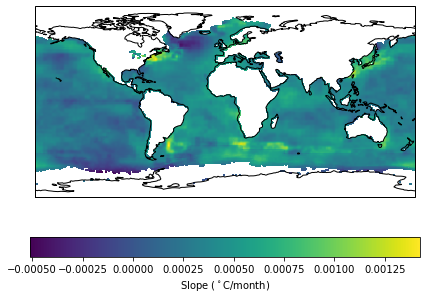

In [10]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection=projection)

lon_grid, lat_grid = np.meshgrid(sst_da[LON_NAME], sst_da[LAT_NAME])

ax.set_global()
ax.coastlines()

cs = ax.pcolor(lon_grid, lat_grid, initial_linear_trends['slope'], transform=ccrs.PlateCarree())

cb = plt.colorbar(cs, ax=ax, orientation='horizontal')
cb.set_label('Slope ($^\circ$C/month)')

plt.show()

plt.close()

## Calculate monthly anomalies

Next, compute the monthly anomalies by removing a linear trend and calculating a
seasonal cycle from the climatology base period.

In [11]:
sst_anom_da, sst_trend_ds, sst_seasonal_cycle_da, base_period = calculate_monthly_anomalies(
    sst_da, period=SEASONAL_CYCLE_PERIOD, trend_order=ANOMALY_TREND_ORDER,
    base_period_start_year=BASE_PERIOD_START_YEAR,
    base_period_end_year=BASE_PERIOD_END_YEAR)

/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


As a sanity check, compute the linear trend on the anomalies to check that it is small.

In [12]:
final_linear_trends = calculate_polynomial_trend(sst_anom_da, trend_order=1)

Maximum linear trend coefficient for anomalies =  <xarray.DataArray 'intcpt' ()>
array(1.12398242e-14)
Minimum linear trend coefficient for anomalies =  <xarray.DataArray 'intcpt' ()>
array(0.)


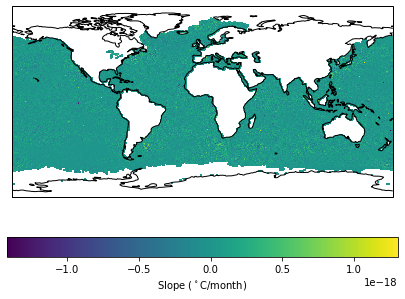

In [13]:
max_final_trend = np.abs(final_linear_trends['intcpt']).max()
print('Maximum linear trend coefficient for anomalies = ', max_final_trend)

min_final_trend = np.abs(final_linear_trends['intcpt']).min()
print('Minimum linear trend coefficient for anomalies = ', min_final_trend)

projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection=projection)

lon_grid, lat_grid = np.meshgrid(sst_da[LON_NAME], sst_da[LAT_NAME])

ax.set_global()
ax.coastlines()

cs = ax.pcolor(lon_grid, lat_grid, final_linear_trends['slope'], transform=ccrs.PlateCarree())

cb = plt.colorbar(cs, ax=ax, orientation='horizontal')
cb.set_label('Slope ($^\circ$C/month)')

plt.show()

plt.close()

Also check that the anomalies and seasonal cycle have approximately zero mean.

Maximum time-mean of anomalies =  <xarray.DataArray ()>
array(1.12562209e-14)
Minimum time-mean of anomalies =  <xarray.DataArray ()>
array(-1.13058953e-14)
Maximum time-mean of seasonal cycle =  <xarray.DataArray ()>
array(1.18423789e-15)
Minimum time-mean of seasonal cycle =  <xarray.DataArray ()>
array(-1.18622487e-15)


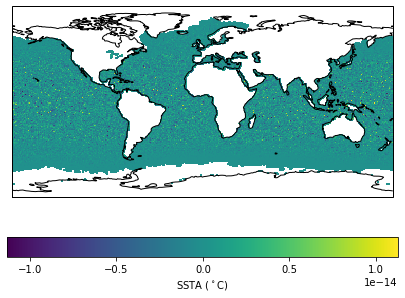

In [14]:
sst_anom_time_mean = sst_anom_da.mean(TIME_NAME)
sst_seasonal_time_mean = sst_seasonal_cycle_da.mean(TIME_NAME)

max_mean_anom = sst_anom_time_mean.max()
print('Maximum time-mean of anomalies = ', max_mean_anom)

min_mean_anom = sst_anom_time_mean.min()
print('Minimum time-mean of anomalies = ', min_mean_anom)

max_seas_anom = sst_seasonal_time_mean.max()
print('Maximum time-mean of seasonal cycle = ', max_seas_anom)

min_seas_anom = sst_seasonal_time_mean.min()
print('Minimum time-mean of seasonal cycle = ', min_seas_anom)

projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection=projection)

lon_grid, lat_grid = np.meshgrid(sst_da[LON_NAME], sst_da[LAT_NAME])

ax.set_global()
ax.coastlines()

cs = ax.pcolor(lon_grid, lat_grid, sst_anom_time_mean, transform=ccrs.PlateCarree())

cb = plt.colorbar(cs, ax=ax, orientation='horizontal')
cb.set_label('SSTA ($^\circ$C)')

plt.show()

plt.close()

Finally, write the calculated anomalies and trends to file.

In [15]:
anom_output_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.nc'.format(base_period[0], base_period[1], ANOMALY_TREND_ORDER))

sst_anom_ds = sst_anom_da.to_dataset(name=(VARIABLE_NAME + '_anom'))
sst_trend_ds = sst_trend_ds.rename({'fitted_value': VARIABLE_NAME + '_trend'})
sst_seasonal_cycle_ds = sst_seasonal_cycle_da.to_dataset(name=(VARIABLE_NAME + '_seasonal_cycle'))

out_ds = xr.merge([sst_anom_ds, sst_trend_ds, sst_seasonal_cycle_ds], join='exact')

out_ds.attrs['input_file'] = SST_INPUT_FILE
out_ds.attrs['base_period_start_year'] = '{:d}'.format(base_period[0])
out_ds.attrs['base_period_end_year'] = '{:d}'.format(base_period[1])
out_ds.attrs['trend_order'] = '{:d}'.format(ANOMALY_TREND_ORDER)
out_ds.attrs['seasonal_cycle_period'] = '{:d}'.format(SEASONAL_CYCLE_PERIOD)
out_ds.attrs['min_valid_threshold'] = '{:16.8e}'.format(MIN_VALID_SST)

out_ds.to_netcdf(anom_output_file)

In addition to the raw anomalies, also compute and save standardized monthly anomalies. The standard deviations
used are computed using the same base period as the climatology.

In [16]:
std_anom_output_file = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.nc'.format(base_period[0], base_period[1], ANOMALY_TREND_ORDER))

base_period_sst_anom_da = sst_anom_da.where(
    (sst_anom_da[TIME_NAME].dt.year >= base_period[0]) &
    (sst_anom_da[TIME_NAME].dt.year <= base_period[1]), drop=True)

sst_anom_mean = base_period_sst_anom_da.groupby(base_period_sst_anom_da[TIME_NAME].dt.month).mean(TIME_NAME)
sst_anom_std = base_period_sst_anom_da.groupby(base_period_sst_anom_da[TIME_NAME].dt.month).std(TIME_NAME)

std_sst_anom_da = xr.apply_ufunc(lambda x, m, s: (x - m) / s, sst_anom_da.groupby(sst_anom_da[TIME_NAME].dt.month), sst_anom_mean, sst_anom_std)

std_sst_anom_ds = std_sst_anom_da.to_dataset(name=(VARIABLE_NAME + '_std_anom'))

out_ds = xr.merge([std_sst_anom_ds, sst_trend_ds, sst_seasonal_cycle_ds], join='exact')

out_ds.attrs['input_file'] = SST_INPUT_FILE
out_ds.attrs['base_period_start_year'] = '{:d}'.format(base_period[0])
out_ds.attrs['base_period_end_year'] = '{:d}'.format(base_period[1])
out_ds.attrs['trend_order'] = '{:d}'.format(ANOMALY_TREND_ORDER)
out_ds.attrs['seasonal_cycle_period'] = '{:d}'.format(SEASONAL_CYCLE_PERIOD)
out_ds.attrs['min_valid_threshold'] = '{:16.8e}'.format(MIN_VALID_SST)

out_ds.to_netcdf(std_anom_output_file)

/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/har1a1/anaconda3/envs/convex-dim-red-expts-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarn

In [17]:
sst_ds.close()